<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tuning-Learning-Rates" data-toc-modified-id="Tuning-Learning-Rates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tuning Learning Rates</a></span><ul class="toc-item"><li><span><a href="#Learning-Rate-Finder" data-toc-modified-id="Learning-Rate-Finder-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Learning Rate Finder</a></span></li><li><span><a href="#Cyclical-Learning-Rate-(CLR)" data-toc-modified-id="Cyclical-Learning-Rate-(CLR)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Cyclical Learning Rate (CLR)</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
# 3. magic for inline plot
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%load_ext watermark
%load_ext autoreload 
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.backend as K
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,keras,matplotlib

Using TensorFlow backend.


Ethen 2018-04-12 15:28:19 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
pandas 0.22.0
keras 2.1.5
matplotlib 2.2.2


# Tuning Learning Rates

Many machine learning algorithms especially in the realms of deep learning uses gradient descent based algorithms to train the model, and this type of numerical optimization requires the end-user to set the learning rate. This parameter tells the optimizer how aggressive should it be in adjusting the weights in the direction of the gradient.

If the learning rate is too low, then training will potentially be more reliable, but the optimization process will take loads of time because steps towards the minimum of the loss function are tiny. On the other hand, if the learning rate is high, then training may not converge or even diverge, as weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

<img src="img/learning_rate.png" width="80%" height="80%">

In this documentation we'll be looking at some ways to determine this critical hyperparameter.

In [3]:
n_classes = 10
n_features = 784  # mnist is a 28 * 28 image

# load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, n_features)
X_test = X_test.reshape(10000, n_features)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255

# convert label to one-hot encoded format so it's keras compatible
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
# define a small sequential model
model = Sequential()
model.add(Dense(512, input_dim = n_features))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

## Learning Rate Finder

One trick to select a reasonable range for our network is to train a network starting from a low learning rate and increase the learning rate exponentially for every batch. We record the learning rate and loss for every batch and when the loss gets a lot higher than the previously observed best value we stop this procedure.

In [8]:
from utils import LRFind

n_epochs = 40
batch_size = 512
validation_split = 0.2
iterations = (X_train.shape[0] * (1 - validation_split)) / batch_size

# use the min_lr and max_lr to set the lower and upper bound
# jump to indicate if the current loss is x times larger than
# the best loss, we should stop the process
lr_find = LRFind(iterations = iterations,
                 min_lr = 0.0001, max_lr = 10, jump = 6)

model.fit(X_train, Y_train, batch_size = batch_size, 
          epochs = n_epochs, verbose = 1,
          validation_split = validation_split,
          callbacks = [lr_find])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
20480/48000 [===========>..................] - ETA: 1s - loss: 1.7402 - acc: 0.4929

Site note: For validation split, the validation dataset will be the last x percentage of the data as keras does not perform a shuffle internally for this split, thus we should ensure there isn't any inherent ordering to our dataset. On the other hand, the training data is shuffle during each epoch since the `shuffle` argument is set to True by default for the fit method.

After this step, we look at the plot with the learning rate versus loss. A typical plot usually starts off with the loss gradually improving with low learning rates, then the training accelerates until the learning rate becomes too large and the training process diverge.

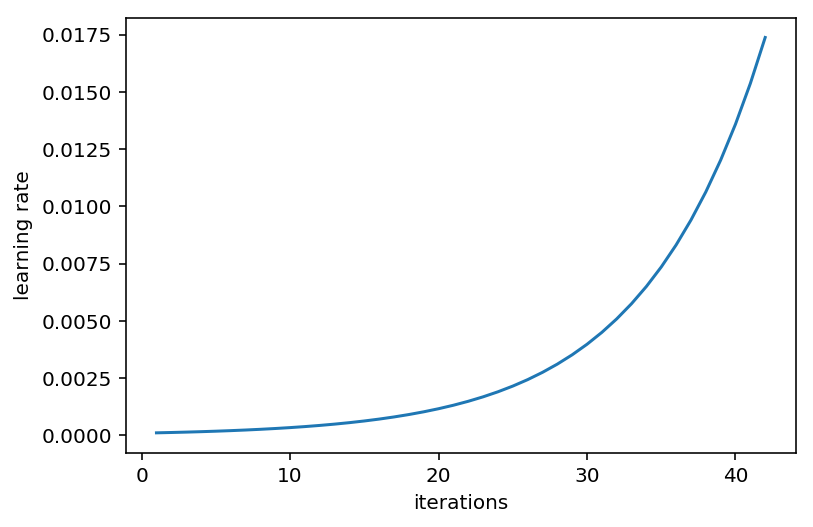

In [9]:
# plot to show the learning rate is increasing for each iterations
lr_find.plot_lr()

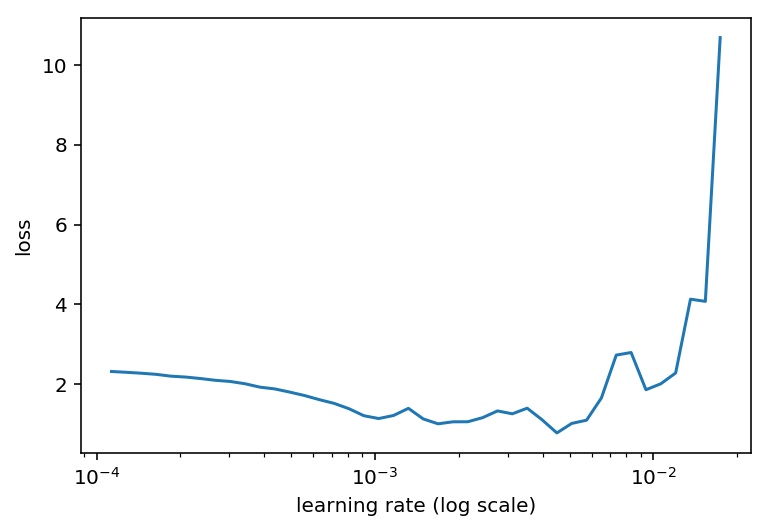

In [10]:
# plot the learning rate versus loss
lr_find.plot_loss()

Looking at the learning rate versus loss plot, we need to select a point on the graph above that's an order of magnitude before the minimum. The rationale for that is: the learning rate that corresponds to the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still improving our score but still on the safe side from an explosion.

In this example, the loss function starts diverging around 0.01, hence we can go back one order of magnitude and set it to 0.001.

In [8]:
K.set_value(model.optimizer.lr, 0.001)

# setup all the things for model fitting and start the training
model_name = 'weights'
address = model_name + '.hdf5'
print('model checkpoint address: ', address)
stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                     patience = 5, verbose = 1, mode = 'auto')
save = ModelCheckpoint(address, monitor = 'val_loss', 
                       verbose = 0, save_best_only = True)
callbacks = [stop, save]

model.save_weights('tmp.h5')
history1 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

model checkpoint address:  weights.hdf5
Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.5507 - acc: 0.8360 - val_loss: 0.1856 - val_acc: 0.9450
Epoch 2/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.1854 - acc: 0.9435 - val_loss: 0.1426 - val_acc: 0.9574
Epoch 3/40
48000/48000 [==============================] - 2s 45us/step - loss: 0.1171 - acc: 0.9641 - val_loss: 0.1126 - val_acc: 0.9665
Epoch 4/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.0844 - acc: 0.9736 - val_loss: 0.0843 - val_acc: 0.9738
Epoch 5/40
48000/48000 [==============================] - 2s 44us/step - loss: 0.0651 - acc: 0.9796 - val_loss: 0.0798 - val_acc: 0.9766
Epoch 6/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.0501 - acc: 0.9842 - val_loss: 0.0807 - val_acc: 0.9776
Epoch 7/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0397 - 

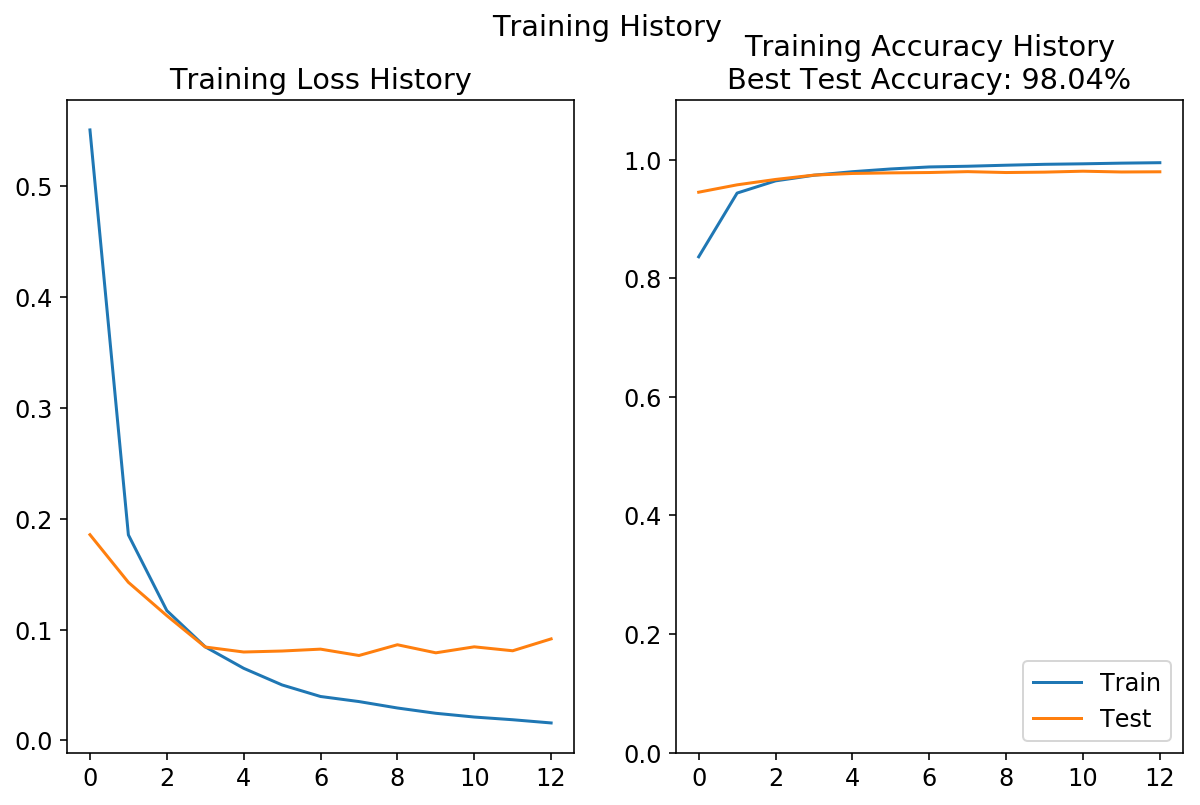

In [23]:
plt.rcParams['font.size'] = 12


def viz_history(history, fig_path = None):
    """Plot keras' history"""
    fig, ax = plt.subplots(1, 2, figsize = (10, 6))
    fig.suptitle('Training History')

    ax[0].plot(history['loss'], label = 'Train')
    ax[0].plot(history['val_loss'], label = 'Test')
    ax[0].set_title('Training Loss History')

    best_acc = np.max(history['val_acc']) * 100
    ax[1].plot(history['acc'], label = 'Train')
    ax[1].plot(history['val_acc'], label = 'Test')    
    ax[1].set_ylim([0, 1.1]) 
    ax[1].set_title('Training Accuracy History\nBest Test Accuracy: {:0.2f}%'.format(best_acc))     
    ax[1].legend(loc = 'lower right', fontsize = 12)

    if fig_path is not None:
        plt.savefig(fig_path)

    plt.show()
    
    
viz_history(history1.history)

In [10]:
# .evaluate gives the loss and metric evaluation score for the dataset
score1 = model.evaluate(X_test, Y_test, verbose = 0)
score1

[0.0766815619190198, 0.9821]

In [11]:
K.set_value(model.optimizer.lr, 0.01)
model.load_weights('tmp.h5')
history2 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 41us/step - loss: 14.3255 - acc: 0.1007 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 2/40
48000/48000 [==============================] - 2s 43us/step - loss: 14.5238 - acc: 0.0989 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 3/40
48000/48000 [==============================] - 2s 43us/step - loss: 14.5238 - acc: 0.0989 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 4/40
48000/48000 [==============================] - 2s 42us/step - loss: 14.5238 - acc: 0.0989 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 5/40
48000/48000 [==============================] - 2s 43us/step - loss: 14.5238 - acc: 0.0989 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 6/40
48000/48000 [==============================] - 2s 42us/step - loss: 14.5238 - acc: 0.0989 - val_loss: 14.5466 - val_acc: 0.0975
Epoch 00006: early stopping


In [12]:
score2 = model.evaluate(X_test, Y_test, verbose = 0)
score2

[14.573981651306152, 0.0958]

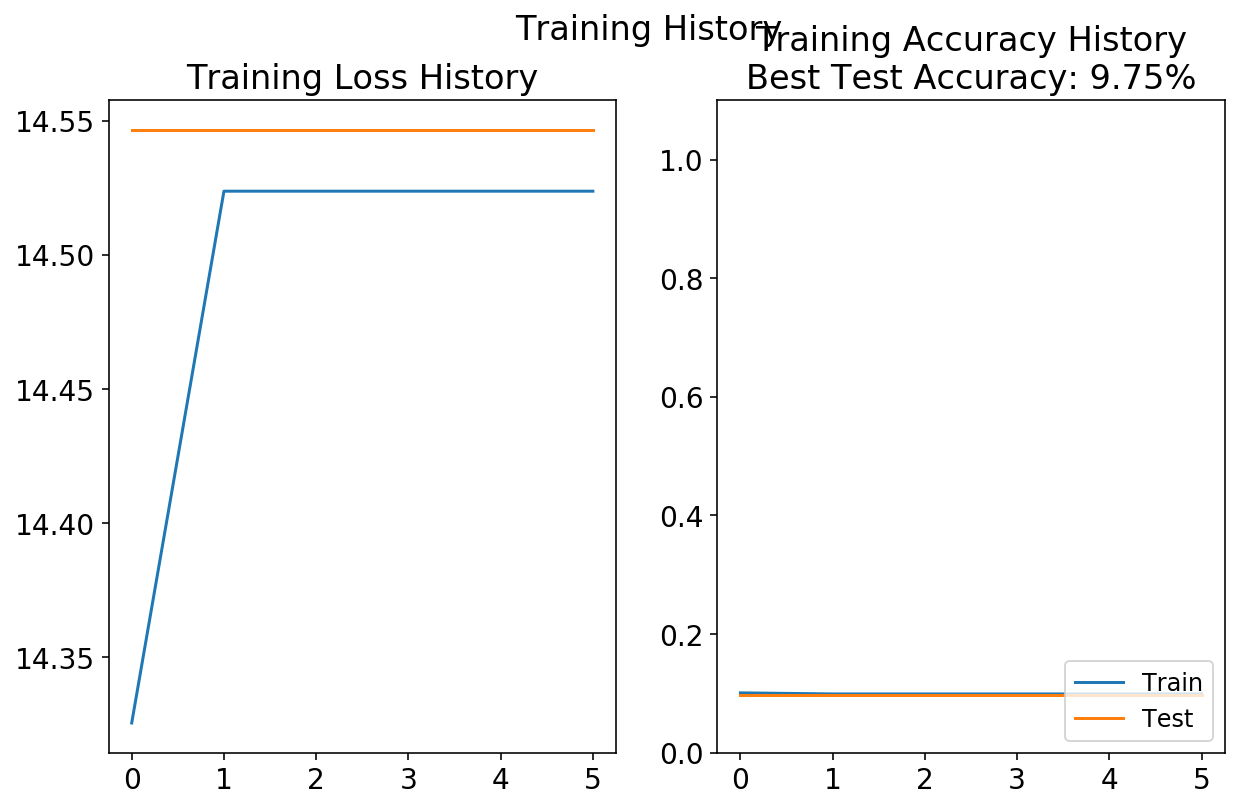

In [13]:
viz_history(history2.history)

In [14]:
K.set_value(model.optimizer.lr, 0.0001)
model.load_weights('tmp.h5')
history3 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 42us/step - loss: 1.0730 - acc: 0.7404 - val_loss: 0.4289 - val_acc: 0.8975
Epoch 2/40
48000/48000 [==============================] - 2s 44us/step - loss: 0.4247 - acc: 0.8795 - val_loss: 0.2889 - val_acc: 0.9204
Epoch 3/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.3233 - acc: 0.9067 - val_loss: 0.2403 - val_acc: 0.9323
Epoch 4/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.2721 - acc: 0.9226 - val_loss: 0.2124 - val_acc: 0.9395
Epoch 5/40
48000/48000 [==============================] - 2s 44us/step - loss: 0.2389 - acc: 0.9307 - val_loss: 0.1894 - val_acc: 0.9466
Epoch 6/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.2121 - acc: 0.9379 - val_loss: 0.1732 - val_acc: 0.9516
Epoch 7/40
48000/48000 [==============================] - 2s 45us/step - loss: 0.1914 - acc: 0.9440 - val_loss: 0.1587 - val_acc

In [15]:
score3 = model.evaluate(X_test, Y_test, verbose = 0)
score3

[0.0646151398246293, 0.9808]

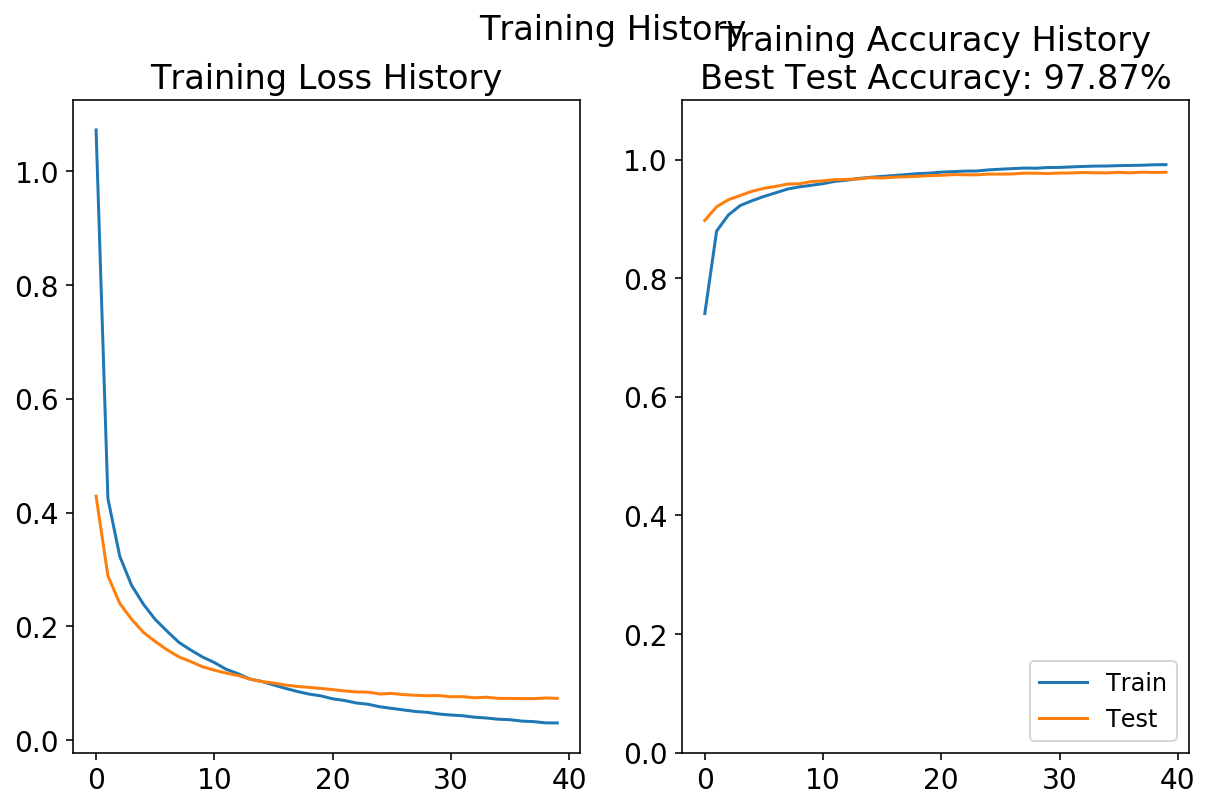

In [16]:
viz_history(history3.history)

## Cyclical Learning Rate (CLR)

Selecting a good starting value for the learning rate is just one part of the problem. Another thing to look out for is the learning schedule, i.e. how to change the learning rate during training. The conventional wisdom is that the learning rate should decrease over time to prevent overshooting the minimum. However, it has been shown it might be useful to periodically vary the learning rate between a lower and upper bound. Although, increasing the learning rate might have a short term negative effect and yet it can be beneficial for the long-run. The reasoning is that the periodic higher learning rates within the training helps the model jump out of any local minima or saddle points if it ever enters into one.

So the general approach is that, after using the learning rate finder to estimate a reasonable learning rate, we use it to estimate the boundary for the CLR policies.

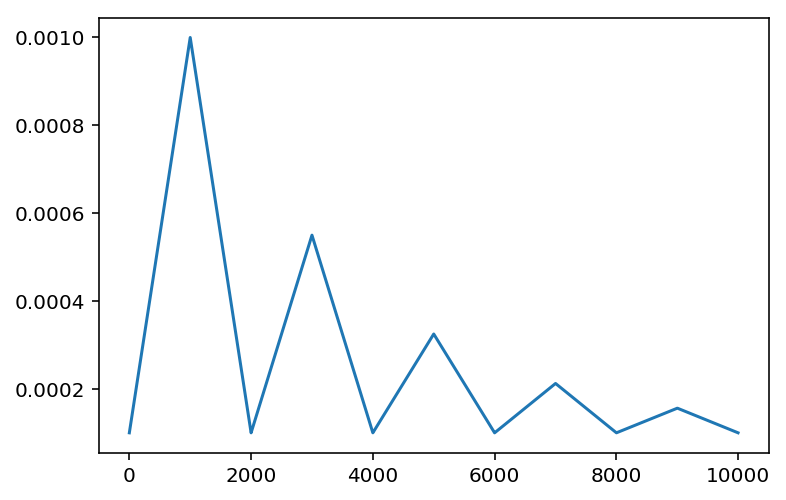

In [13]:
# Demo of how the learning rate varies with iterations

def get_triangular2_lr(iteration, step_size, min_lr, max_lr):
    """triangular 2 learning rate"""
    cycle = np.floor(1 + iteration / (2 * step_size))
    x = np.abs(iteration / step_size - 2 * cycle + 1)
    triangle_scaling = np.maximum(0, (1 - x)) / (2 ** (cycle - 1))
    return min_lr + (max_lr - min_lr) * triangle_scaling


n_iterations = 10000
stepsize = 1000
min_lr = 0.0001
max_lr = 0.001
lr_trend = [get_triangular2_lr(iteration, stepsize, min_lr, max_lr)
            for iteration in range(n_iterations)]

plt.plot(lr_trend)
plt.show()

This policy is easy to implement compared with adaptive learning methods and incurs essentially no additional computational expense.

In [17]:
# from utils import CyclicLR, LRCycle
from utils import LRCycle

# step size = 2 ~ 10 times the number of iterations in an epoch
# clr_triangular = CyclicLR(mode = 'triangular2', base_lr = 0.0001, max_lr = 0.001, step_size = 250)
clr_triangular = LRCycle(min_lr = 0.0001, max_lr = 0.001, step_size = iterations * 2)
callbacks = [stop, save, clr_triangular]

model.load_weights('tmp.h5')
history4 = model.fit(X_train, Y_train, batch_size = batch_size, 
                     epochs = n_epochs, verbose = 1,
                     validation_split = validation_split,
                     callbacks = callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.8483 - acc: 0.7733 - val_loss: 0.3081 - val_acc: 0.9035
Epoch 2/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.2747 - acc: 0.9177 - val_loss: 0.2253 - val_acc: 0.9323
Epoch 3/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.1541 - acc: 0.9541 - val_loss: 0.1134 - val_acc: 0.9652
Epoch 4/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.0970 - acc: 0.9710 - val_loss: 0.0946 - val_acc: 0.9707
Epoch 5/40
48000/48000 [==============================] - 2s 42us/step - loss: 0.0801 - acc: 0.9762 - val_loss: 0.0927 - val_acc: 0.9728
Epoch 6/40
48000/48000 [==============================] - 2s 41us/step - loss: 0.0755 - acc: 0.9771 - val_loss: 0.0969 - val_acc: 0.9696
Epoch 7/40
48000/48000 [==============================] - 2s 43us/step - loss: 0.0643 - acc: 0.9807 - val_loss: 0.0772 - val_acc

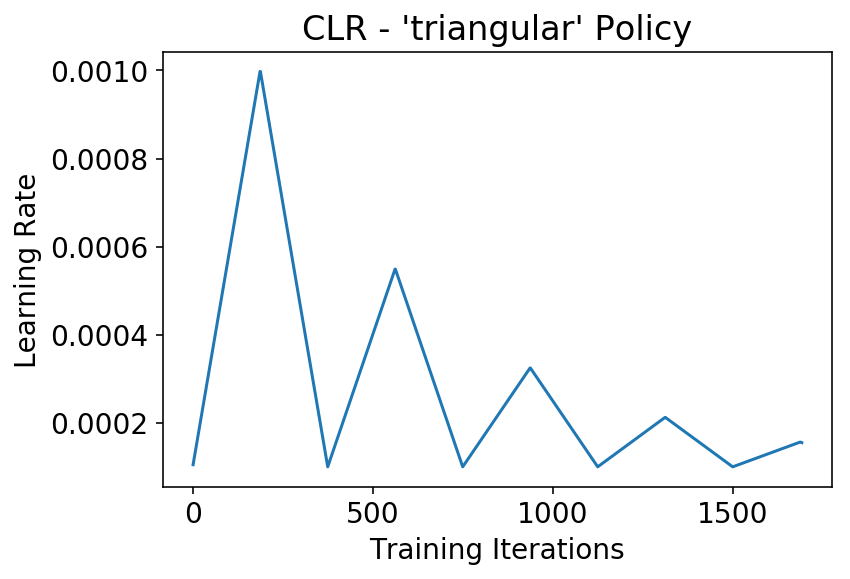

In [20]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])
plt.show()

In [21]:
score4 = model.evaluate(X_test, Y_test, verbose = 0)
score4

[0.06183361943198252, 0.982]

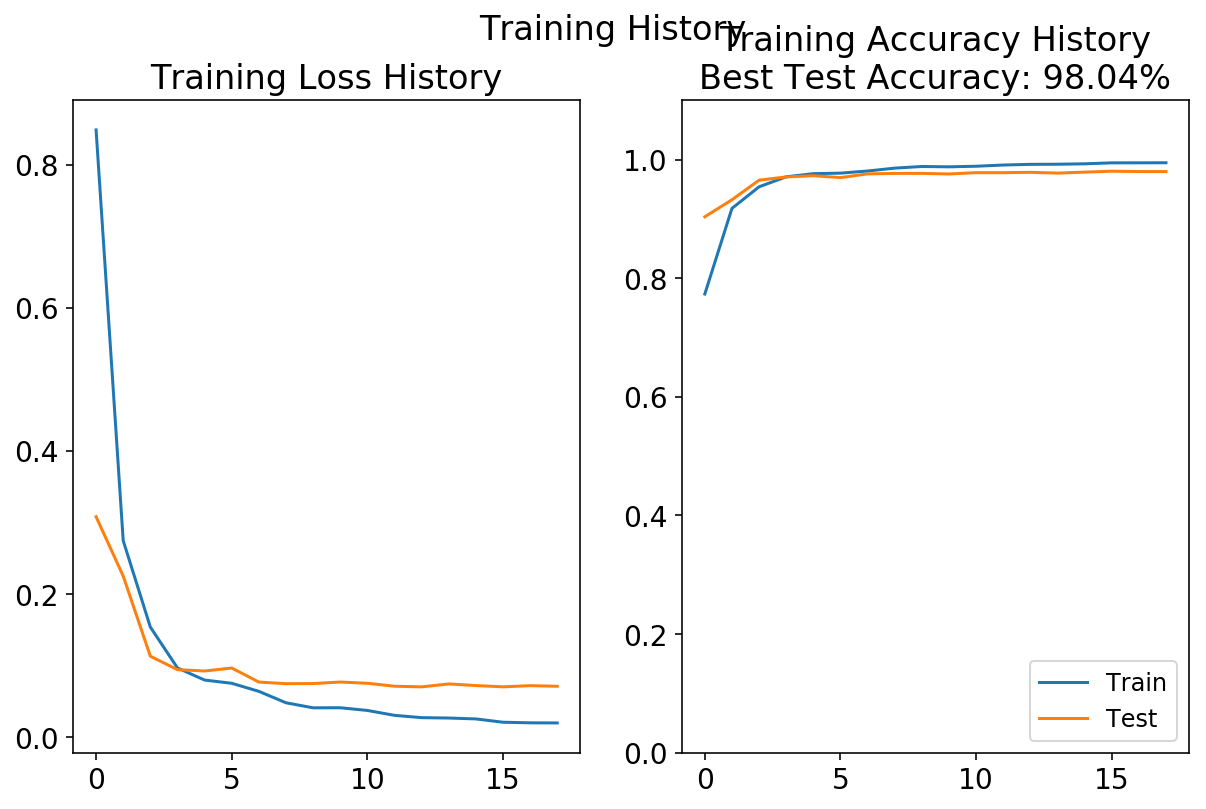

In [22]:
viz_history(history4.history)

Note that selecting a learning rate once, before training, is not enough. The optimal learning rate decreases while training. You can rerun the same learning rate search procedure periodically to find the learning rate at a later point in the training process.

# Reference

- [Blog: Improving the way we work with learning rate](https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b)
- [Blog: Estimating an Optimal Learning Rate For a Deep Neural Network](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)